In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import sympy

from scipy.optimize import minimize
import pyswarms as ps

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.set_matplotlib_formats('retina')
sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Solver

This code initializes generator state variables and network terminal variables

In [2]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb])
    
    return x, V, c

This code solves non-liear constraint optimization

In [3]:
def constraint_objective(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    res = np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    return np.linalg.norm(res, 2) ** 2

def constraint_objective2(theta, x, xx, c, S):
    return constraint_objective(x, xx, c, S, theta)

def constraint_jacobian(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [ra, -x1d, id, -iq],
        [xq, ra, iq, id],
        [(x1d * xq + ra ** 2), 0, vd, vq],
        [0, (x1d * xq + ra ** 2), vq, -vd]
    ])
    
    return m @ dif

def constraint_jacobian2(theta, x, xx, c, S):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [0, 0, 0, 0],
        [2 * ra * id + vd, 2 * ra * iq - e1q + vq, 0, 0],
        [xq * id, xq * iq - vd, 0, 0],
        [0, 0, 0, 0],
        [x1d * id - e1q + vq, x1d * iq, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    
    return m @ dif

def constraint_solve(x, V, c, S, theta, threshold=1e-16):
    if constraint_objective(V, x, c, S, theta) < threshold:
        return V
    else:
        return minimize(constraint_objective,
                        x0=V,
                        args=(x, c, S, theta),
                        method='L-BFGS-B',
                        jac=constraint_jacobian, bounds=[(0., None)] * 4).x

This code defines transition from one time step to another

In [4]:
def transition(x, V, c, S, theta, tau=0.1, tol=1e-16):
    delta, w, v2, vs, vm, vr, vf, e1q = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    
    Vnew = constraint_solve(x, V, c, S, theta, threshold=tol)
    vd, vq, id, iq = Vnew
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    xnew = x + tau * np.array([
        w - ws,
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])
    
    xnew[3] = max(vsmin, min(vsmax, xnew[3]))
    xnew[6] = max(vfmin, min(vfmax, xnew[6]))
    
    return xnew, Vnew

In [42]:
def f(x, V, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vd, vq, id, iq = V
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    res = np.array([
        w - ws,
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])
    return res

In [48]:
def transition_rk(x, V, c, S, theta, tau=0.1, tol=1e-16):
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    Vnew = constraint_solve(x, V, c, S, theta, threshold=tol)
    
    k1 = tau * f(x, Vnew, c, S, theta)
    k2 = tau * f(x + k1 / 2, Vnew, c, S, theta)
    k3 = tau * f(x + k2 / 2, Vnew, c, S, theta)
    k4 = tau * f(x + k3, Vnew, c, S, theta)
    
    xnew = x + (k1 + 2 * (k2 + k3) + k4) / 6
    
    xnew[3] = max(vsmin, min(vsmax, xnew[3]))
    xnew[6] = max(vfmin, min(vfmax, xnew[6]))
    
    return xnew, Vnew

This code defines interface to solver in one function call

In [44]:
def solve(df, tau=0.1, tol=1e-16):
    theta0 = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta0)
    xs = [x0]
    Vs = [V0]
    for t in range(1, len(df)):
        xnew, Vnew = transition(xs[-1], Vs[-1], c, df[['p', 'q']].values[t], theta0, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs

def solve_for_theta(injection, theta, tau=0.1, tol=1e-16):
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta)
    xs = [x0]
    Vs = [V0]
    for t in range(1, injection.shape[0]):
        xnew, Vnew = transition(xs[-1], Vs[-1], c, injection[t], theta, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs, c

def solve_rk(injection, theta, tau=0.1, tol=1e-16):
    x0, V0, c = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta)
    xs = [x0]
    Vs = [V0]
    for t in range(1, injection.shape[0]):
        xnew, Vnew = transition_rk(xs[-1], Vs[-1], c, injection[t], theta, tau=tau, tol=tol)
        xs.append(xnew)
        Vs.append(Vnew)
        
    return xs, Vs, c

## Learner

In [45]:
def objective(theta, inj, ref, tol=1e-16):
    x, v, c = solve_for_theta(inj, theta * scale, tau=0.0001, tol=tol)
    vr = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for xx, vv in zip(x, v)]).reshape((1, -1))
    vi = np.array([- vv[0] * np.cos(xx[0]) + vv[1] * np.sin(xx[0]) for xx, vv in zip(x, v)]).reshape((1, -1))
    vvals = np.vstack([vr, vi]).T
    vrefs = np.zeros((len(ref), 2))
    for t, v in enumerate(ref):
        vt = v[0]
        anglev = v[1]
        v = vt * np.exp(1j * anglev)
        vrefs[t, 0] = v.real
        vrefs[t, 1] = v.imag
    return vvals, vrefs, np.mean(np.linalg.norm(vvals-vrefs, ord=2, axis=1) ** 2, axis=0)

def objective_rk(theta, inj, ref, tol=1e-16):
    x, v, c = solve_rk(inj, theta * scale, tau=0.0001, tol=tol)
    vr = np.array([vv[0] * np.sin(xx[0]) + vv[1] * np.cos(xx[0]) for xx, vv in zip(x, v)]).reshape((1, -1))
    vi = np.array([- vv[0] * np.cos(xx[0]) + vv[1] * np.sin(xx[0]) for xx, vv in zip(x, v)]).reshape((1, -1))
    vvals = np.vstack([vr, vi]).T
    vrefs = np.zeros((len(ref), 2))
    for t, v in enumerate(ref):
        vt = v[0]
        anglev = v[1]
        v = vt * np.exp(1j * anglev)
        vrefs[t, 0] = v.real
        vrefs[t, 1] = v.imag
    return vvals, vrefs, np.mean(np.linalg.norm(vvals-vrefs, ord=2, axis=1) ** 2, axis=0)

## Testing

In [7]:
df = pd.read_csv('./exportedVariables.csv')

In [8]:
df.head()

,time,machine3.gen3.P,machine3.gen3.Q,machine3.gen3.v,machine3.gen3.anglev
0,0.0000,19.98,9.67925,1.0,28.3429
1,0.0001,19.98,9.67925,1.0,28.3429
2,0.0002,19.98,9.67925,1.0,28.3429
3,0.0003,19.98,9.67925,1.0,28.3429
4,0.0004,19.98,9.67925,1.0,28.3429


In [9]:
df = df.drop_duplicates('time')

In [10]:
df = df.drop(['time'], axis=1)

In [11]:
df.columns = ['p', 'q', 'v', 'phi']

In [12]:
df.phi = df.phi * np.pi / 180

### Testing solver

In [50]:
vvals, vrefs, v = objective_rk(theta_true_scaled, df[['p', 'q']].values, df[['v', 'phi']].values)
print(v)

3.969788701571794e-06


### Bayesian low-dim

In [28]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])
scale = np.array([10., 0.01, 1., 10., 10.,
                  10., 1., 10., 10., 10., 0.1,
                  0.1, 0.1, 1., 1., 0.001, 1000])
theta_true_scaled = theta_true / scale

In [29]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(10, 17, options)
# 1 particle = 4 s
# 5 particles = 44 s
# 10 particles = 140 s

In [30]:
def opt_fn(x):
    return objective(x, df[['p', 'q']].values, df[['v', 'phi']].values, 1e-3)[2]

def opt_fn_rk(x):
    return objective_rk(x, df[['p', 'q']].values, df[['v', 'phi']].values, 1e-3)[2]

In [31]:
best_cost, best_pos = optimizer.optimize(lambda x: np.apply_along_axis(opt_fn, 1, x), 10, fast=True)

2019-04-13 15:28:45,169 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}






pyswarms.single.global_best:   0%|          |0/10





pyswarms.single.global_best:   0%|          |0/10, best_cost=0.000538





pyswarms.single.global_best:  10%|█         |1/10, best_cost=0.000538





pyswarms.single.global_best:  10%|█         |1/10, best_cost=0.000538





pyswarms.single.global_best:  20%|██        |2/10, best_cost=0.000538





pyswarms.single.global_best:  20%|██        |2/10, best_cost=0.000538





pyswarms.single.global_best:  30%|███       |3/10, best_cost=0.000538





pyswarms.single.global_best:  30%|███       |3/10, best_cost=0.000538





pyswarms.single.global_best:  40%|████      |4/10, best_cost=0.000538





pyswarms.single.global_best:  40%|████      |4/10, best_cost=0.000538





pyswarms.single.global_best:  50%|█████     |5/10, best_cost=0.000538/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/ipykern

In [32]:
theta0 = best_pos

In [33]:
nm_result = minimize(opt_fn, x0=theta0, method='Nelder-Mead', tol=1e-6)

In [37]:
opt_fn(nm_result.x)

4.184391761892774e-06

In [38]:
vvals, vrefs, _ = objective(nm_result.x, df[['p', 'q']].values, df[['v', 'phi']].values)

Text(0.5, 1.0, 'Vi')

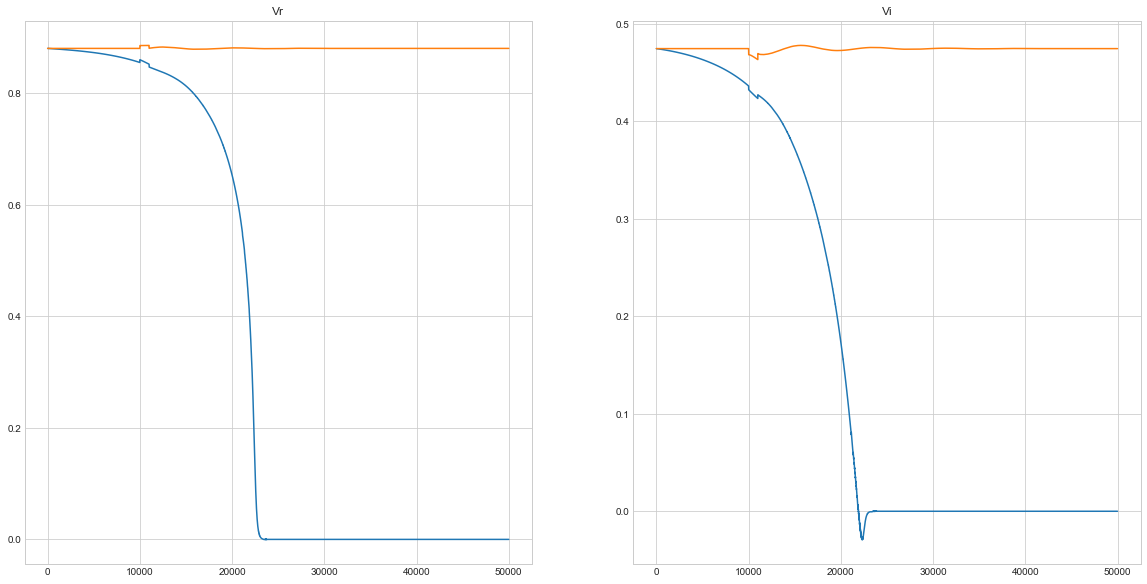

In [41]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(vvals[:, 0], label='pred')
ax[0].plot(vrefs[:, 0], label='true')
ax[0].set_title('Vr')
ax[1].plot(vvals[:, 1], label='pred')
ax[1].plot(vrefs[:, 1], label='true')
ax[1].set_title('Vi')

In [ ]:
bfgs_result = minimize(opt_fn, x0=theta0, method='BFGS', tol=1e-6)

### Testing learner

In [ ]:
old_settings = np.seterr(all='raise')

In [ ]:
theta_pred = learning(injection=df[['p', 'q']].values,
                      reference=df['v'].values,
                      stepsize=lambda k: max(1e-5, 1 / (1 + k % 50)), steps=1000,
                      alpha=0, eps=1e-8, nu=1e3, mu=1e3)
print(learning_scale(theta_pred))

In [ ]:
x, v, c = solve_for_theta(df[['p', 'q']].values, learning_scale(theta_pred), tau=0.0001)

In [ ]:
Vs = [np.sqrt(xx[0] ** 2 + xx[1] ** 2) for xx in v]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Vs, label='predicted')
plt.plot(df.v.values, label='true')
# plt.plot(np.abs(df.v.values - Vs))
plt.legend()

In [ ]:
np.seterr(**old_settings)

In [ ]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])
# ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta

In [ ]:
ra, x1d, xq, e1q, p, q, vd, vq, delta = sympy.symbols('ra x1d xq e1q p q vd vq delta')

In [ ]:
solution = sympy.solve_poly_system([-ra*vd**2 -ra*vq**2+(x1d-xq)*vd*vq +xq*vd*e1q +e1q*ra*vq-(x1d*xq+ra**2)*p,
                                    -x1d*vd**2-xq*vq**2-ra*vd*e1q+vq*xq*e1q-(x1d*xq+ra**2)*q], vd, vq)

In [ ]:
x, v, c = get_initial_values(P0=1997.9999999936396,
                             Q0=967.9249699065775,
                             V0=1.0,
                             angle0=0.494677176989154,
                             theta0=theta_true)

In [ ]:
xval, yval = solution[1][0], solution[1][1]

In [ ]:
solution[0][0]

In [ ]:
sympy.N(sympy.sqrt((xval * sympy.sin(delta) + yval * sympy.cos(delta)) ** 2 + \
                   (-xval * sympy.cos(delta) + yval * sympy.sin(delta)) ** 2),
        subs={ra: 3e-3, x1d: 0.3, xq: 1.76, e1q: x[-1], p: 19.97, q: 9.67, delta: x[0]})

In [ ]:
sympy.N(-ra*vd**2 -ra*vq**2+(x1d-xq)*vd*vq +xq*vd*e1q +e1q*ra*vq-(x1d*xq+ra**2)*p, 
        subs={ra: 3e-3, x1d: 0.3, xq: 1.76, e1q: x[-1], p: 19.97, q: 9.67,
              delta: x[0], vd: solution[0][0], vq: solution[0][1]})

In [ ]:
np.sqrt(v[0] ** 2 + v[1] ** 2)

In [ ]:
x[0]

## New objective